In [1]:
import numpy as np
import cv2 as cv
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
from google.colab import drive
import os
import zipfile
drive.mount('/content/drive')
zip_path = '/content/drive/My Drive/IPM/archive.zip'

output_dir = '/content/extracted_data'
os.makedirs(output_dir,exist_ok=True)

with zipfile.ZipFile(zip_path,'r') as zip:
  zip.extractall(output_dir)
print('completed!')


Mounted at /content/drive
completed!


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

def increase_data(path,folder_name,category_name):
    for file in tqdm(os.listdir(path)):
                if file.endswith('.jpg'):
                    img_path = os.path.join(path,file)
                    img = load_img(img_path)
                    img = img_to_array(img)
                    img = img = img.reshape((1,) + img.shape)
                    datagen = ImageDataGenerator(
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')
                    i = 0
                    for batch in datagen.flow(img, batch_size=1, save_to_dir=folder_name, save_prefix=category_name, save_format='jpg'):
                        i += 1
                        if i > 9:
                            break

In [4]:
increase_data('extracted_data/train/disgust','extracted_data/train/disgust','disgust')

100%|██████████| 436/436 [00:06<00:00, 63.01it/s]


In [5]:
def df_maker(path,target_size=(48,48)):
    images = []
    category = []
    print(f"\n\npath is {path}:")
    for folder in os.listdir(path):
        print(f"Processing {folder}'s Faces")
        folder_path = os.path.join(path, folder)
        for file in tqdm(os.listdir(folder_path)):
            if file.endswith('.jpg'):
                img_path = os.path.join(folder_path,file)
                img = cv.imread(img_path,cv.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv.resize(img,(target_size),interpolation=cv.INTER_LINEAR)
                    images.append(img)
                    category.append(folder)
    return pd.DataFrame({
        'image': images,
        'category': category
    })

In [6]:
train_images = df_maker(r'extracted_data/train').sample(frac=1).reset_index(drop=True)
test_images = df_maker(r'extracted_data/test').sample(frac=1).reset_index(drop=True)
train_images['category'] = train_images['category'].map({'angry' : 0,'disgust' : 1,'fear' : 2,'happy' : 3,'neutral' : 4,'sad' : 5,'surprise' : 6})
test_images['category'] = test_images['category'].map({'angry' : 0,'disgust' : 1,'fear' : 2,'happy' : 3,'neutral' : 4,'sad' : 5,'surprise' : 6})



path is extracted_data/train:
Processing angry's Faces


100%|██████████| 3995/3995 [00:00<00:00, 14269.91it/s]


Processing fear's Faces


100%|██████████| 4097/4097 [00:00<00:00, 15546.67it/s]


Processing surprise's Faces


100%|██████████| 3171/3171 [00:00<00:00, 14765.79it/s]


Processing disgust's Faces


100%|██████████| 3980/3980 [00:00<00:00, 17296.33it/s]


Processing sad's Faces


100%|██████████| 4830/4830 [00:00<00:00, 15768.67it/s]


Processing neutral's Faces


100%|██████████| 4965/4965 [00:00<00:00, 15745.28it/s]


Processing happy's Faces


100%|██████████| 7215/7215 [00:00<00:00, 15162.12it/s]




path is extracted_data/test:
Processing angry's Faces


100%|██████████| 958/958 [00:00<00:00, 17067.54it/s]


Processing fear's Faces


100%|██████████| 1024/1024 [00:00<00:00, 15961.85it/s]


Processing surprise's Faces


100%|██████████| 831/831 [00:00<00:00, 16101.16it/s]


Processing disgust's Faces


100%|██████████| 111/111 [00:00<00:00, 12427.40it/s]


Processing sad's Faces


100%|██████████| 1247/1247 [00:00<00:00, 15126.91it/s]


Processing neutral's Faces


100%|██████████| 1233/1233 [00:00<00:00, 15731.32it/s]


Processing happy's Faces


100%|██████████| 1774/1774 [00:00<00:00, 16442.00it/s]


In [7]:
x_train = np.stack(train_images['image'].values)
y_train = train_images['category'].values.reshape(-1,1)
x_test = np.stack(test_images['image'].values)
y_test = test_images['category'].values.reshape(-1,1)


In [8]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [9]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((32253, 48, 48, 1), (32253, 1), (7178, 48, 48, 1), (7178, 1))

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [11]:
num_emotions = y_train.shape[1]


In [12]:
model = Sequential()
model.add(Conv2D(48,(3,3),padding='same',input_shape=x_train.shape[1:],activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(96,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Conv2D(192,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(x_train.shape[1],'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(num_emotions,'softmax'))




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 48)          │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 96)          │          41,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 192)         │         166,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 384)         │         663,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 13824)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 13824)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13824)               │          55,296 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │         663,6

 Total params: 1,594,375 (6.08 MB)

 Trainable params: 1,565,191 (5.97 MB)

 Non-trainable params: 29,184 (114.00 KB)

In [15]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=30,batch_size=64)


Epoch 1/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - accuracy: 0.2923 - loss: 1.9083 - val_accuracy: 0.1804 - val_loss: 2.1102
Epoch 2/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.5124 - loss: 1.2984 - val_accuracy: 0.4114 - val_loss: 1.7816
Epoch 3/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.5811 - loss: 1.1235 - val_accuracy: 0.4976 - val_loss: 1.3915
Epoch 4/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.6122 - loss: 1.0465 - val_accuracy: 0.5708 - val_loss: 1.1345
Epoch 5/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.6338 - loss: 0.9783 - val_accuracy: 0.5706 - val_loss: 1.1472
Epoch 6/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.6525 - loss: 0.9331 - val_accuracy: 0.5740 - val_loss: 1.1170
Epoch 7/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.6723 - loss: 0.8823 - val_accuracy: 0.5425 - val_loss: 1.3220
Epoch 8/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.6939 - loss: 0.8303 - 

<Axes: >

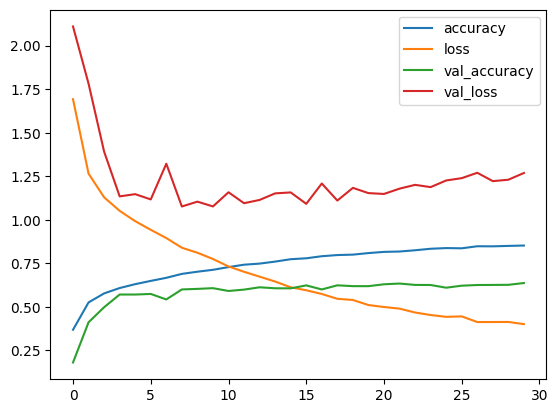

In [16]:
pd.DataFrame(history.history).plot()

In [17]:
model.save('CNN_FER2013.h5')

In [18]:
from tensorflow.keras.models import load_model
model_load = load_model('CNN_FER2013.h5')

In [19]:
prediction = model_load.predict(x_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [20]:
prediction = np.argmax(prediction,axis=1)
y_test = np.argmax(y_test,axis=1)


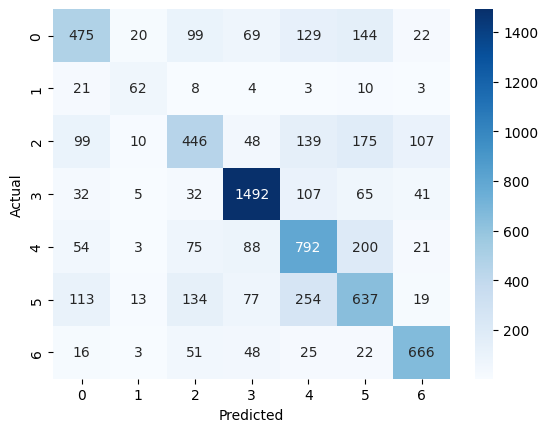

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
import cv2
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)
cam = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
emotions = ['angry','disgust','fear','happy','neutral','sad','surprise']
while True:
    check,frame = cam.read()
    gray_img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    face = face_classifier.detectMultiScale(
    gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
    )
    if len(face) > 0:
        x,y,h,w = face[0]
        cropped_face = frame[y:y+h,x:x+w]
        pred = model_load.predict(cropped_face)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,200,100),0.5)
        label = emotions[np.argmax(pred,axis=1)]
        cv2.putText(frame,label,(50,50),font,1,(0,200,100),1,cv2.Line_4)



    cv2.imshow('video',frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
cam.release()
cv2.destroyAllWindows()

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
